# Mean Shift
#### Basic Implementation
The following two functions find_peak and meanshift execute the basic mean shift algorithm.

In [140]:
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.io import loadmat
from sklearn.datasets import *
from IPython.core.display import clear_output
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

##### Load  and visualize sample data
The matrix is loaded into a numpy array of dimensions (2000, 3)

In [146]:
SAMPLE_DATA = loadmat("pts.mat")['data']
if False:  # Set to true to show the data
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(SAMPLE_DATA[0], SAMPLE_DATA[1], SAMPLE_DATA[2])

##### Utility functions


In [142]:
def dist(p1, p2):
    """ Returns the euclidian distance between p1 and p2."""
    return np.sqrt(np.sum(p1-p2)**2)
    

def get_neighbours(data, point, r):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The distance at which points are considered neighbours
    :return: A list of points with a euclidian distance < r.
    """
    ret = []
    
    for d in data:
        if dist(point, d)<r:
            ret.append(d)
    return np.array(ret)

In [162]:
def find_peak(data, point, r):
    """
    :data: The n-dimensional dataset containing p points
    :point: The data point for which the density peak will be computed
    :r: The search windows radius
    :return: The found peak.
    """
    neighbours = get_neighbours(data, point, r)
    peak = neighbours.mean(axis=0)
    return peak

def meanshift(data, r):
    """
    Calls find_peak for every point in data. 
    Similar peaks are merged after each call, if their distance is smaller than r/2.
    :data: The n-dimensional dataset containing p points
    :r: The search windows radius
    :return: A list of peaks and a list of points, annotated with the index of their peak.
    """
    peaks = []
    annotated = {
        "points": [],
        "peaks": []
    }
    data_transposed = data.transpose()
    for idx, point in enumerate(data_transposed):
        if idx*1./len(data_transposed)*100 % 5 == 0:
            clear_output()
            print("{:.2f} % done ...".format(idx*1./len(data_transposed)*100, end="\r"))
        peak = find_peak(data_transposed, point, r)
        neighbours = get_neighbours(peaks, peak, r/2)
        if len(neighbours) == 0:
            peaks.append(peak)
        else:
            peak = neighbours[0]
        annotated["points"].append(point)
        annotated["peaks"].append(np.where(peaks==peak)[0][0])
    annotated["points"] = np.array(annotated["points"])
    annotated["points"] = annotated["points"].transpose()
    annotated["peaks"] = np.array(annotated["peaks"], dtype=np.float32)
    return peaks, annotated

##### Execute the meanshift function
Visualize the results

95.00 % done ...


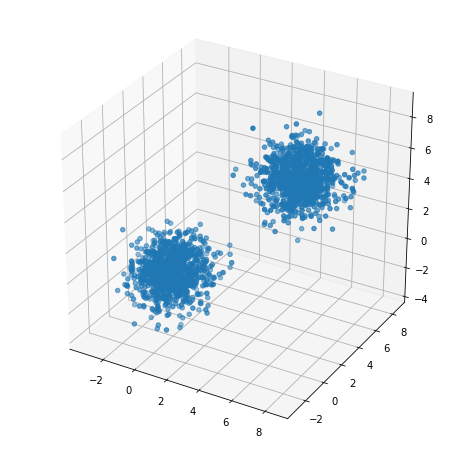

In [163]:
peaks, annotated = meanshift(SAMPLE_DATA, r=0.1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(annotated["points"][0], annotated["points"][1], annotated["points"][2])
ax.scatter(peaks[0], peaks[1], peaks[2], color="red", s=4)